In [7]:
import tensorflow as tf
from keras import layers
from keras.datasets import mnist
from keras.layers import Dropout
from tensorflow import keras

import matplotlib.pyplot as plt

In [8]:
# images path
import os, pathlib, shutil
new_img_path = pathlib.Path("../dataset/facemask_images_small")

Prepare images for training

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    directory=new_img_path / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    directory=new_img_path / "val",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    directory=new_img_path / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 900 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 260 files belonging to 2 classes.


In [10]:
for data_batch, labels_batch in train_dataset:
    print("Data batch shape: ", data_batch.shape)

    print("Labels batch shape: ", labels_batch.shape)
    break

2022-04-11 12:21:48.457450: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 47775744 exceeds 10% of free system memory.


Data batch shape:  (32, 180, 180, 3)
Labels batch shape:  (32,)


In [11]:
# Data augmentation for bigger sample space
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [16]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1. / 255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)

outputs = layers.Dense(units=1, activation='sigmoid')(x)
model_base = keras.Model(inputs=inputs, outputs=outputs)

In [17]:
model_base.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [18]:
model_base.compile(
    optimizer=keras.optimizers.Adam(lr=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
    )

/home/avizyt/anaconda3/envs/tflow/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="../models/checkpoints/facemask_image_clf_1.keras",
        save_best_only=True,
        monitor='val_accuracy'
    )
]

In [20]:
history = model_base.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/10


2022-04-11 12:38:44.061782: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 47775744 exceeds 10% of free system memory.
2022-04-11 12:38:45.009937: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 129777664 exceeds 10% of free system memory.
2022-04-11 12:38:45.528595: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32444416 exceeds 10% of free system memory.
2022-04-11 12:38:45.575688: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62005248 exceeds 10% of free system memory.


29/29 [==============================] - 47s 1s/step - loss: 0.6851 - accuracy: 0.5478 - val_loss: 0.3953 - val_accuracy: 0.9000
Epoch 2/10
29/29 [==============================] - 42s 1s/step - loss: 0.1744 - accuracy: 0.9411 - val_loss: 0.1080 - val_accuracy: 0.9750
Epoch 3/10
29/29 [==============================] - 43s 1s/step - loss: 0.0745 - accuracy: 0.9756 - val_loss: 0.0745 - val_accuracy: 0.9700
Epoch 4/10
29/29 [==============================] - 44s 1s/step - loss: 0.4189 - accuracy: 0.8822 - val_loss: 0.3499 - val_accuracy: 0.8850
Epoch 5/10
29/29 [==============================] - 42s 1s/step - loss: 0.0845 - accuracy: 0.9733 - val_loss: 0.2887 - val_accuracy: 0.9150
Epoch 6/10
29/29 [==============================] - 43s 1s/step - loss: 0.0972 - accuracy: 0.9722 - val_loss: 0.0621 - val_accuracy: 0.9800
Epoch 7/10
29/29 [==============================] - 42s 1s/step - loss: 0.0576 - accuracy: 0.9867 - val_loss: 0.0534 - val_accuracy: 0.9800
Epoch 8/10
29/29 [=============

In [30]:
test_model = keras.models.load_model("../models/checkpoints/facemask_image_clf_1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss},Test Accuracy: {test_acc}")

9/9 [==============================] - 3s 292ms/step - loss: 0.0696 - accuracy: 0.9885
Test Loss: 0.06961962580680847,Test Accuracy: 0.9884615540504456


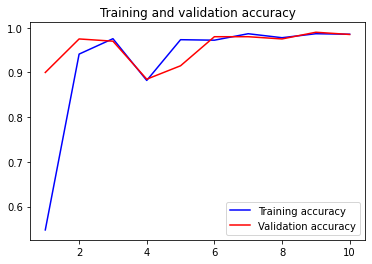

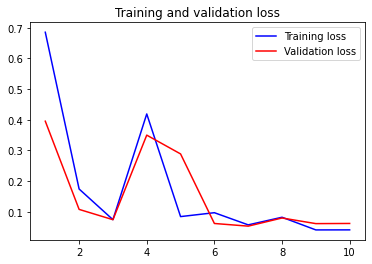

In [31]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy,color='blue', label="Training accuracy")
plt.plot(epochs, val_accuracy, color='red', label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, color='blue', label="Training loss")
plt.plot(epochs, val_loss, color='red', label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [32]:
model_base.save("facemask_new.h5", history)